# Dados de vendas de farmácias dinamarquesas para abril de 2023

In [101]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb




In [102]:
df = pd.read_csv("pharmacy_sales_april_2023.csv")
df.head()

,SaleID,Time,DrugID,DrugName,DrugClass,Price,ExpDate,Quantity
0,12005226,4/1/2023 9:04,D0051,Ciprofloxacin,Psychotropic,106,2024-03,6
1,12005226,4/1/2023 9:04,D0051,Olmesartan,Analgesic,170,2023-10,2
2,12005227,4/1/2023 9:05,D0049,Donepezil,Antiviral,184,2024-03,5
3,12005227,4/1/2023 9:05,D0061,Fexofenadine,Hormonal,54,2023-05,6
4,12005227,4/1/2023 9:05,D0034,Naproxen,Respiratory,50,2024-01,3


## 1. Analisando os valores faltantes e chacando inconsistências

<Axes: >

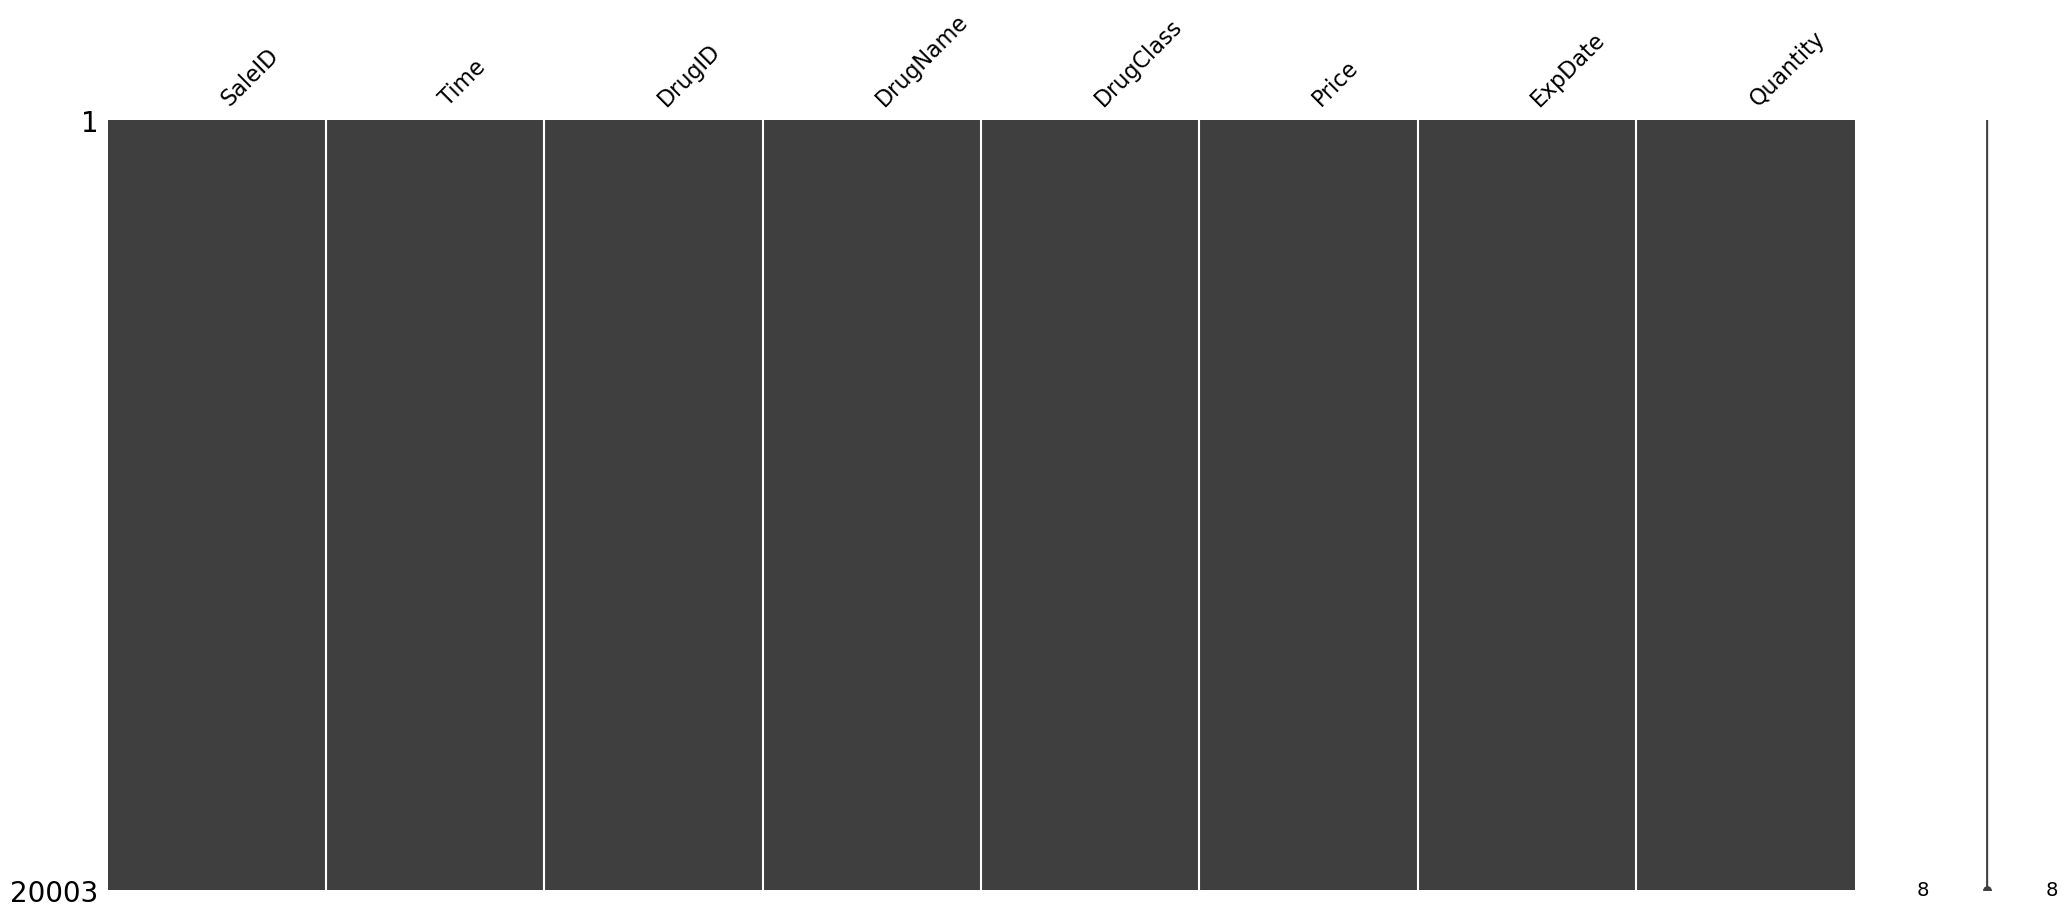

In [103]:
msno.matrix(df)

## 2. Explorando os dados

### Quantidade vendida descrescente

In [104]:
df.groupby('DrugName')['Quantity'].sum().sort_values(ascending=False)


DrugName
Escitalopram           1345
Senna                  1332
Oxycodone              1293
Trazodone              1263
Polyethylene Glycol    1251
                       ... 
Dorzolamide             964
Linagliptin             962
Digoxin                 904
Brimonidine             868
Bupropion               862
Name: Quantity, Length: 100, dtype: int64

### Receita por medicamento em ordem decrescente

In [105]:
df['Revenue'] = df['Price'] * df['Quantity']
df.groupby('DrugName')['Revenue'].sum().sort_values(ascending=False)


DrugName
Azithromycin    231110
Saxagliptin     227556
Sertraline      227400
Clonazepam      223716
Clindamycin     217917
                 ...  
Topiramate       32973
Warfarin         28840
Lubiprostone     28269
Dorzolamide      26992
Bupropion        23274
Name: Revenue, Length: 100, dtype: int64

### Padrões de expiração por medicamento:

In [106]:
df.groupby('ExpDate')['DrugName'].count().sort_values(ascending=True)


ExpDate
2024-04     727
2023-05    1007
2023-11    1728
2024-02    1734
2023-09    1800
2023-10    1805
2023-07    1833
2023-06    1847
2024-01    1850
2023-12    1859
2024-03    1881
2023-08    1932
Name: DrugName, dtype: int64

### Padrões de venda ao longo do tempo

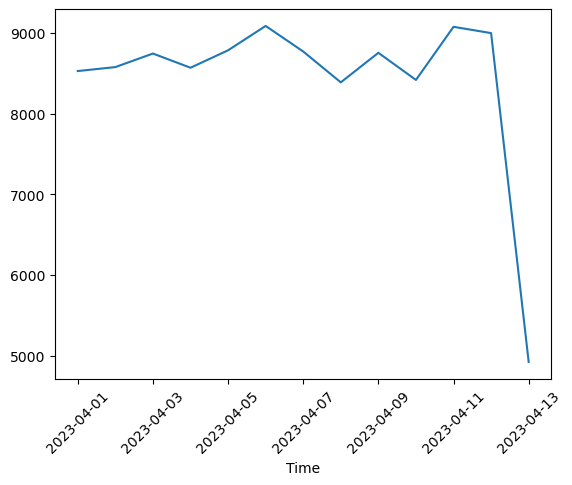

In [107]:
# Convertendo a coluna 'Time' para o formato datetime
df['Time'] = pd.to_datetime(df['Time'])

# Agrupando as quantidades por data
daily_sales = df.groupby(df['Time'].dt.date)['Quantity'].sum()

# Criando o gráfico de linha
ax = daily_sales.plot(kind='line')

# Obtendo os rótulos do eixo X
xticks = ax.get_xticks()

# Verificando se há rótulos suficientes para aplicar espaçamento
if len(xticks) > 10:
    ax.set_xticks(xticks[::len(xticks) // 10])  # Exibindo 10 rótulos no eixo X

# Rotacionando os rótulos para melhor visualização
plt.xticks(rotation=45)

# Exibindo o gráfico
plt.show()

### Medicamentos de alto risco

In [108]:
df[df['DrugClass'].isin(['Psychotropic', 'Hormonal'])].groupby('DrugClass')['Quantity'].sum()


DrugClass
Hormonal         9516
Psychotropic    11540
Name: Quantity, dtype: int64

### Distribuição de preço por classe de medicamento:

<Axes: title={'center': 'Price'}, xlabel='DrugClass'>

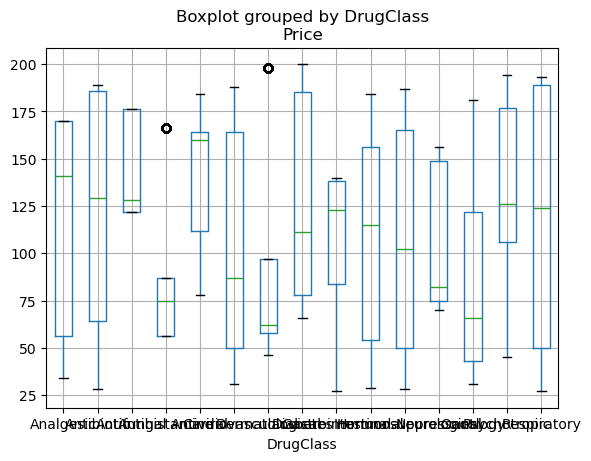

In [109]:
df.boxplot(column='Price', by='DrugClass')


## 3. Criando a variável de receita para predição

In [110]:
# Convertendo a coluna 'Time' para o formato datetime
df['Time'] = pd.to_datetime(df['Time'])


In [111]:
# Extraindo features temporais
df['Year'] = df['Time'].dt.year
df['Month'] = df['Time'].dt.month

# Calculando a receita
df['Revenue'] = df['Price'] * df['Quantity']

# Definindo a variável target (receita do próximo mês)
df['NextMonthRevenue'] = df.groupby(['DrugID', 'Year', 'Month'])['Revenue'].transform(lambda x: x.shift(-1))

# Dropando valores nulos que surgiram após o shift
df.dropna(subset=['NextMonthRevenue'], inplace=True)

In [112]:
df.head()

,SaleID,Time,DrugID,DrugName,DrugClass,Price,ExpDate,Quantity,Revenue,Year,Month,NextMonthRevenue
0,12005226,2023-04-01 09:04:00,D0051,Ciprofloxacin,Psychotropic,106,2024-03,6,636,2023,4,340.0
1,12005226,2023-04-01 09:04:00,D0051,Olmesartan,Analgesic,170,2023-10,2,340,2023,4,318.0
2,12005227,2023-04-01 09:05:00,D0049,Donepezil,Antiviral,184,2024-03,5,920,2023,4,184.0
3,12005227,2023-04-01 09:05:00,D0061,Fexofenadine,Hormonal,54,2023-05,6,324,2023,4,216.0
4,12005227,2023-04-01 09:05:00,D0034,Naproxen,Respiratory,50,2024-01,3,150,2023,4,100.0


In [113]:
print(df.dtypes)


SaleID                       int64
Time                datetime64[ns]
DrugID                      object
DrugName                    object
DrugClass                   object
Price                        int64
ExpDate                     object
Quantity                     int64
Revenue                      int64
Year                         int32
Month                        int32
NextMonthRevenue           float64
dtype: object


In [114]:
# Codificando a variável categórica 'DrugID' usando get_dummies
df = pd.get_dummies(df, columns=['DrugID'], drop_first=True)


In [115]:
df = df.drop('SaleID', axis=1)

In [116]:
df.head()

,Time,DrugName,DrugClass,Price,ExpDate,Quantity,Revenue,Year,Month,NextMonthRevenue,...,DrugID_D0083,DrugID_D0085,DrugID_D0088,DrugID_D0091,DrugID_D0092,DrugID_D0093,DrugID_D0095,DrugID_D0098,DrugID_D0099,DrugID_D0100
0,2023-04-01 09:04:00,Ciprofloxacin,Psychotropic,106,2024-03,6,636,2023,4,340.0,...,False,False,False,False,False,False,False,False,False,False
1,2023-04-01 09:04:00,Olmesartan,Analgesic,170,2023-10,2,340,2023,4,318.0,...,False,False,False,False,False,False,False,False,False,False
2,2023-04-01 09:05:00,Donepezil,Antiviral,184,2024-03,5,920,2023,4,184.0,...,False,False,False,False,False,False,False,False,False,False
3,2023-04-01 09:05:00,Fexofenadine,Hormonal,54,2023-05,6,324,2023,4,216.0,...,False,False,False,False,False,False,False,False,False,False
4,2023-04-01 09:05:00,Naproxen,Respiratory,50,2024-01,3,150,2023,4,100.0,...,False,False,False,False,False,False,False,False,False,False


In [117]:
df['Time'] = pd.to_datetime(df['Time']).dt.date


In [118]:
df.head()

,Time,DrugName,DrugClass,Price,ExpDate,Quantity,Revenue,Year,Month,NextMonthRevenue,...,DrugID_D0083,DrugID_D0085,DrugID_D0088,DrugID_D0091,DrugID_D0092,DrugID_D0093,DrugID_D0095,DrugID_D0098,DrugID_D0099,DrugID_D0100
0,2023-04-01,Ciprofloxacin,Psychotropic,106,2024-03,6,636,2023,4,340.0,...,False,False,False,False,False,False,False,False,False,False
1,2023-04-01,Olmesartan,Analgesic,170,2023-10,2,340,2023,4,318.0,...,False,False,False,False,False,False,False,False,False,False
2,2023-04-01,Donepezil,Antiviral,184,2024-03,5,920,2023,4,184.0,...,False,False,False,False,False,False,False,False,False,False
3,2023-04-01,Fexofenadine,Hormonal,54,2023-05,6,324,2023,4,216.0,...,False,False,False,False,False,False,False,False,False,False
4,2023-04-01,Naproxen,Respiratory,50,2024-01,3,150,2023,4,100.0,...,False,False,False,False,False,False,False,False,False,False


In [133]:
df.NextMonthRevenue.skew()

0.8686316841511297

In [134]:
df.NextMonthRevenue.describe()

count    19937.000000
mean       621.955660
std        459.929796
min         27.000000
25%        248.000000
50%        500.000000
75%        905.000000
max       2000.000000
Name: NextMonthRevenue, dtype: float64

## 4. Modelos de predição:


In [119]:
# Separando variáveis independentes (features) e dependentes (target)
X = df[['Price', 'Month', 'Year', 'Quantity'] + [col for col in df.columns if 'DrugID_' in col]]
y = df['NextMonthRevenue']


In [120]:
# Dividindo em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [121]:
# Inicializando e treinando o modelo de Regressão Linear
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [122]:
# Fazendo previsões
y_pred = model.predict(X_test)

In [123]:
# Avaliando o modelo
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse}")

RMSE: 402.07364771370857


/home/taffaleo/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


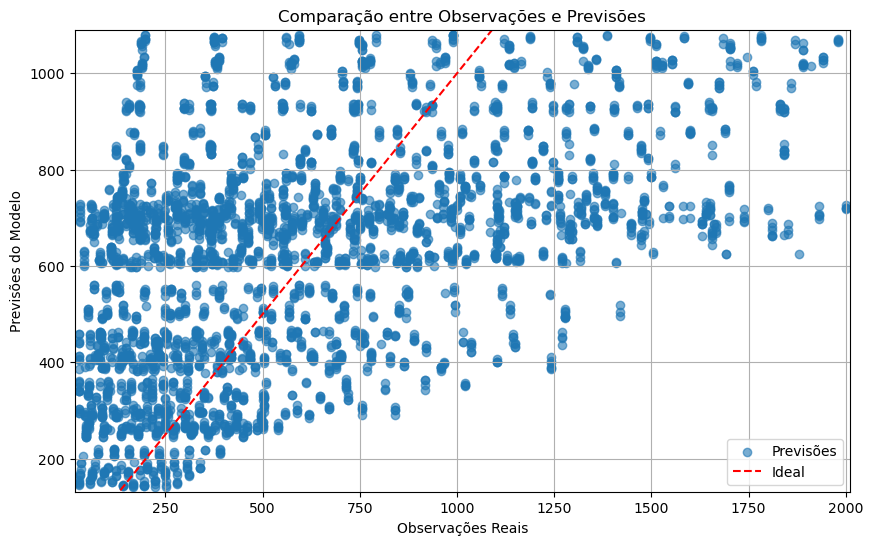

In [124]:
# Criando um DataFrame para armazenar as previsões e os valores reais
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

# Criando um gráfico de dispersão
plt.figure(figsize=(10, 6))
plt.scatter(results['Actual'], results['Predicted'], alpha=0.6, label='Previsões')  # Adicionando label

# Linha de referência
plt.plot([results['Actual'].min(), results['Actual'].max()],
         [results['Actual'].min(), results['Actual'].max()], 
         color='red', linestyle='--', label='Ideal')  # Adicionando label

# Configurando título e rótulos
plt.title('Comparação entre Observações e Previsões')
plt.xlabel('Observações Reais')
plt.ylabel('Previsões do Modelo')

# Ajuste de limites dos eixos
plt.xlim(results['Actual'].min() - 10, results['Actual'].max() + 10)  
plt.ylim(results['Predicted'].min() - 10, results['Predicted'].max() + 10)

# Adicionando a legenda
plt.legend()

plt.grid()
plt.show()


In [125]:
# Divida os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crie o modelo de Ridge
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)

# Faça previsões
y_pred_ridge = ridge_model.predict(X_test)

# Calcule RMSE
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
print(f'RMSE da Regressão Ridge: {rmse_ridge}')


RMSE da Regressão Ridge: 402.41147508016513


In [126]:
# Crie o modelo de Lasso
lasso_model = Lasso(alpha=1.0)
lasso_model.fit(X_train, y_train)

# Faça previsões
y_pred_lasso = lasso_model.predict(X_test)

# Calcule RMSE
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
print(f'RMSE da Regressão Lasso: {rmse_lasso}')


RMSE da Regressão Lasso: 414.2559978308259


In [127]:
# Crie o modelo de Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Faça previsões
y_pred_rf = rf_model.predict(X_test)

# Calcule RMSE
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f'RMSE do Random Forest: {rmse_rf}')


RMSE do Random Forest: 412.2383559309393


In [128]:
# Crie o modelo SVR
svr_model = SVR(kernel='rbf')  # Usando um kernel radial
svr_model.fit(X_train, y_train)

# Faça previsões
y_pred_svr = svr_model.predict(X_test)

# Calcule RMSE
rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))
print(f'RMSE do SVR: {rmse_svr}')


RMSE do SVR: 470.3510792036366


In [129]:
from sklearn.ensemble import GradientBoostingRegressor

# Crie o modelo de Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

# Faça previsões
y_pred_gb = gb_model.predict(X_test)

# Calcule RMSE
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
print(f'RMSE do Gradient Boosting: {rmse_gb}')


RMSE do Gradient Boosting: 409.8761771999322


In [130]:
# Crie o modelo KNN
knn_model = KNeighborsRegressor(n_neighbors=5)  # Você pode ajustar o número de vizinhos
knn_model.fit(X_train, y_train)

# Faça previsões
y_pred_knn = knn_model.predict(X_test)

# Calcule RMSE
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))
print(f'RMSE do KNN: {rmse_knn}')


RMSE do KNN: 434.6702693065827


In [131]:
#pip install xgboost


In [132]:
# Crie o modelo XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Faça previsões
y_pred_xgb = xgb_model.predict(X_test)

# Calcule RMSE
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f'RMSE do XGBoost: {rmse_xgb}')


RMSE do XGBoost: 407.3795828765663
